# Backtesting
### Price
Use ``price`` to get the current price of a symbol. Given a number, it will go back that amount of days, which can be used to compute averages, etc.
### Available Capital & Capital
While ``capital`` is the current value of your portfolio + cash, ``available_capital`` is capital not tied up in securities only.
### Order
Use ``order`` to enter a long trade of the given ticker, using the given funds (either use an absolute number or a percentage when passing ``as_percent=True``). To enter a short position, pass ``short=True``.
### Portfolio
``portfolio`` is a dataframe that contains information about all currently held positions.
### Liquidate
Use ``liquidate`` to get out of positions. Simply pass a filter for ``portfolio`` and all entries matching it will be liquidated.

In [1]:
from simple_back.backtester import BacktesterBuilder
from simple_back.strategy import BuyAndHold, SellAndHold
from datetime import date
from dateutil.relativedelta import relativedelta
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

## Iterator
The backtester object can be iterated over to run simple strategies.
It exposes ``day`` (e.g. 2010-01-01), ``event`` ('open' or 'close') and itself.

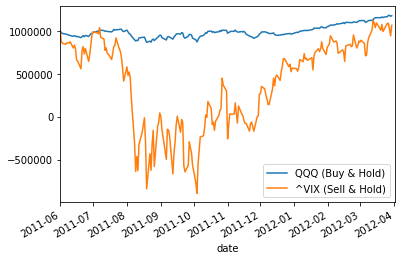

In [2]:
ticker = 'QQQ'
bt = (
BacktesterBuilder()
  .name('My Backtest')
  .balance(1_000_000)
  .strategies(['QQQ', SellAndHold('^VIX')])
  .live_plot()
  .calendar('NYSE')
  .build()
)

"""
for day, event, b in bt['2011-06-01':'2012-04-02']:
    # calculate average price of the ticker over the last 30 days
    avg_open = b.prices[ticker,-30:]['open'].mean()
    
    if day == date(2011,6,1) and event == 'open':
        b.order_abs('ETR', b.price('ETR')*261)
        
    if day == date(2011,10,3) and event == 'open':
        b.order_abs('ETR', b.price('ETR')*86.1)
"""
bt['2011-06-01':'2012-04-02'].run()

In [19]:
from datetime import datetime, tzinfo
import pytz
import pandas_market_calendars as mcal

Timestamp('2020-06-03 13:12:31.830317+0000', tz='UTC')

In [35]:
mcal.get_calendar('NYSE').schedule(date.today()-relativedelta(days=10), date.today()).loc['2020-5-26']['market_open']

Timestamp('2020-05-26 13:30:00+0000', tz='UTC')

In [22]:
np.tile(['open', 'close'], 2)

array(['open', 'close', 'open', 'close'], dtype='<U5')

In [2]:
ticker = '^GSPC'

class Monthly:
    def __init__(self):
        self.last_month = None
        
    def __call__(self, day, event, bt):
        if day.month != self.last_month:
            self.last_month = day.month
            try:
                bt.order_abs(ticker, bt.balance.start / 12)
            except Exception as e:
                pass
            
class NDayLow:
    def __init__(self, n_days):
        self.n_days=n_days
        self.n_days_since=None
        
    def __call__(self, day, event, bt):
        if event == 'open':
            if self.n_days_since is not None:
                self.n_days_since += 1
        if (bt.price(ticker)<bt.prices[ticker,-(self.n_days+1):-1]).all().all():
            try:
                if self.n_days_since is None or self.n_days_since > 30:
                    bt.order_abs(ticker, bt.balance.start / 12)
                    self.n_days_since = 0
            except:
                pass
        
bt = BacktesterBuilder().balance(12_0000).calendar('NYSE').live_metrics().build()
bts = bt[-relativedelta(years=10):].run([Monthly(),NDayLow(50)])

NameError: name 'BacktesterBuilder' is not defined

In [3]:
bts[1].metrics['Portfolio Value'].df

NameError: name 'bts' is not defined

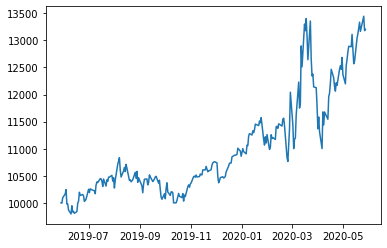

In [8]:
plt.plot(bt.metrics['Total Value'].df['open'])

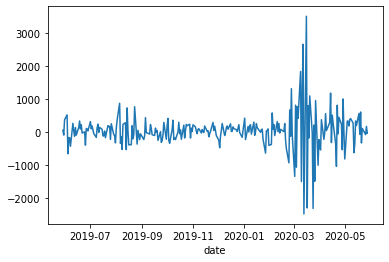

In [5]:
bt.metrics['Profit/Loss'].df.sum(axis=1).plot()